In [1]:
import gc
import time
import pandas as pd
import matplotlib.pyplot as plt
from abc import ABC, abstractmethod
from collections.abc import MutableMapping
from pathlib import Path
from random import randrange
from tempfile import TemporaryDirectory

import dabble

In [2]:
class Benchmark(ABC):
    def __init__(self, storage_class: MutableMapping, iterations: int):
        self._iterations = iterations
        self._storage_class = storage_class
        self._store_location = TemporaryDirectory().name     
        
    def setup(self):
        """An opportunity to setup the benchmark. This is not timed."""
        self._store = self._storage_class(Path(self._store_location))
        
    @abstractmethod
    def iterate(self, iteration: int):
        """Does 1 unit of work."""
        
    def run(self) -> list[float]:
        timings = []
        gc.disable()
        try:
            self.setup()
            for iteration in range(self._iterations):
                start_time = time.time()
                self.iterate(iteration)
                timings.append(time.time() - start_time)
        finally:
            gc.enable()
        return timings
        
        
class SequentialSetAndGet(Benchmark):
    """Repeatedly sets and gets a sequence of key-value pairs.

    Tests read-after-write performance.
    """
    def iterate(self, iteration: int):
        self._store[f"key_{iteration}"] = f"value_{iteration}"
        self._store[f"key_{iteration}"]
        
        
class SequentialSets(Benchmark):
    """Repeatedly sets a sequence of key-value pairs.

    A decent indication of write-throughput.
    """
    def iterate(self, iteration: int):
        self._store[f"key_{iteration}"] = f"value_{iteration}"
        
class SequentialGets(Benchmark):
    """Repeatedly gets a sequence of keys.

    The store is pre-filled with a bunch of data before we just read all keys sequentially.
    """
    def setup(self):
        super().setup()
        for i in range(self._iterations):
            self._store[f"key_{i}"] = f"value_{i}"
            
    def iterate(self, iteration: int):
        self._store[f"key_{iteration}"] = f"value_{iteration}"

class RandomGets(Benchmark):
    """Repeatedly gets random keys.

    The store is pre-filled with a bunch of data before we just do random gets.
    """
    def setup(self):
        super().setup()
        for i in range(self._iterations):
            self._store[f"key_{i}"] = f"value_{i}"
            
    def iterate(self, iterations: int):
        i = randrange(self._iterations)
        self._store[f"key_{i}"]

In [3]:
def run_benchmarks(implementation_class, iterations):
    timings = {}
    for benchmark_class in Benchmark.__subclasses__():
        benchmark = benchmark_class(
            storage_class=implementation_class, 
            iterations=iterations
        )
        timings[benchmark_class.__name__] = benchmark.run()
        
    return pd.DataFrame(timings)

In [4]:
def run_and_plot_benchmarks(iterations, implementation_classes=None):
    import importlib
    importlib.reload(dabble)
    
    timings = {}
    implementation_classes = set(implementation_classes or dabble.KVStore.__subclasses__())
    for implementation_class in implementation_classes:
        timings[implementation_class.__name__] = run_benchmarks(implementation_class, iterations)
        
    per_benchmark_timings = {
        benchmark.__name__: pd.DataFrame({
            implementation: df[benchmark.__name__]
            for implementation, df in timings.items()
        })
        for benchmark in Benchmark.__subclasses__()
    }

    fig, axes = plt.subplots(len(per_benchmark_timings), 1, figsize=(20, 20))
    for i, (benchmark_name, benchmark_timings) in enumerate(per_benchmark_timings.items()):
        benchmark_timings.plot(title=benchmark_name, ax=axes[i])

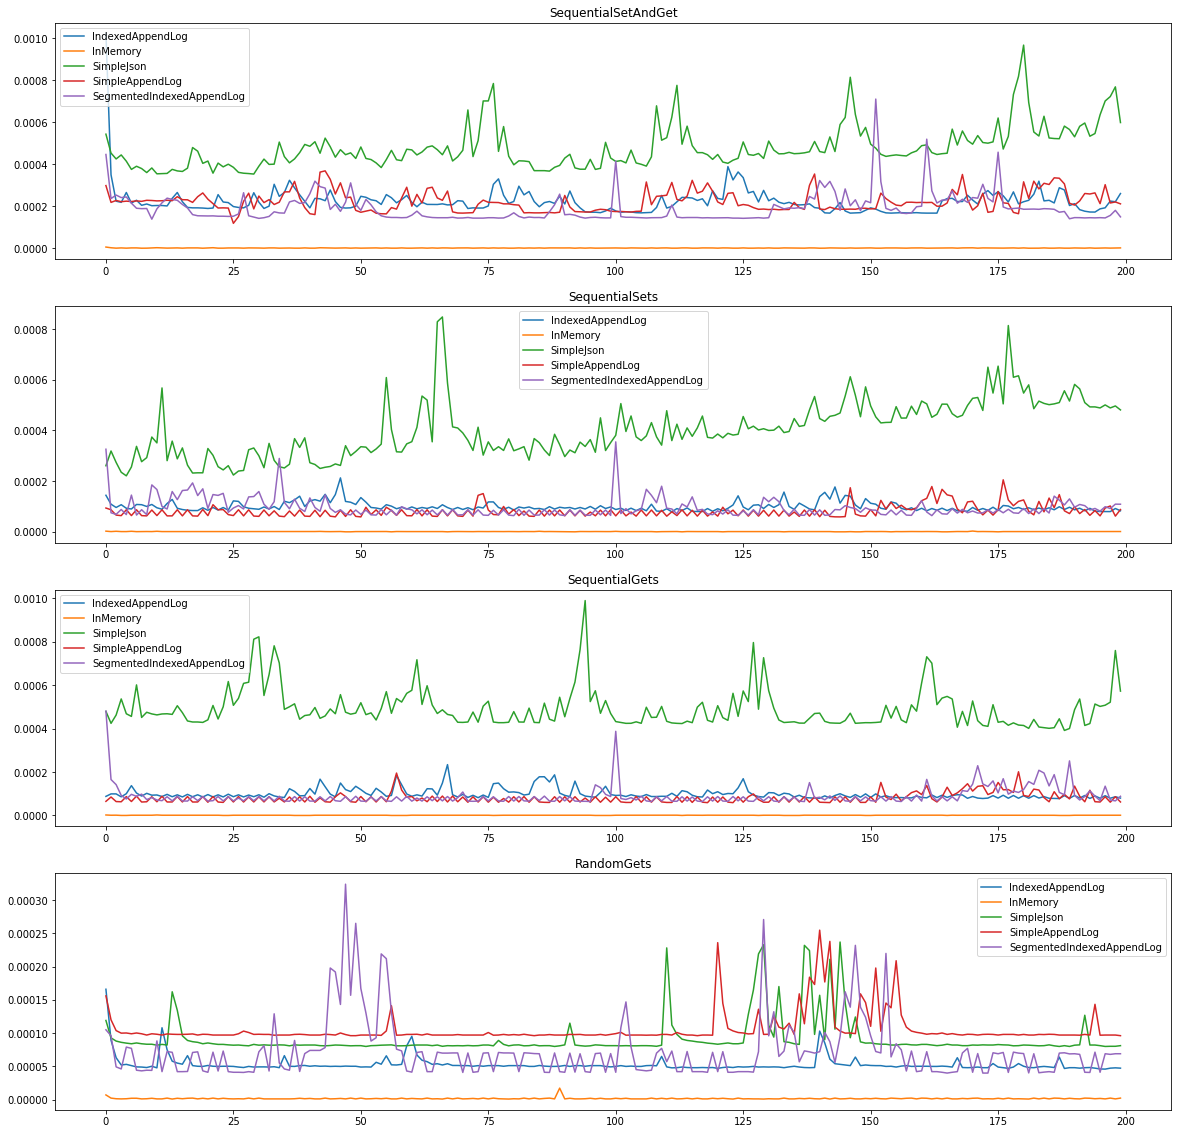

In [5]:
run_and_plot_benchmarks(200)